# Learning energies and forces

In [1]:
import theano.tensor as T
from theano import function, scan
import numpy as np
import matplotlib.pyplot as plt

## Introduzione

Assumendo che l'energia si possa scrivere come somma su tutte le triplette del sistema unicamente definite $ t \in T_{\rho}$

$$ E(\rho) = \sum_{t}^{\in T_{\rho}} \varepsilon(\mathbf{q}_{t}) . $$

A questo punto un kernel per le energie si formalmente scrivere come 

$$ k_{EE}(\rho,\rho') = \langle E(\rho) E(\rho') \rangle .$$

Usando la decomposizione in triplette questo di trasforma in

$$ k_{EE}(\rho,\rho') = \sum_{t}^{\in T_{\rho}} \sum_{t'}^{\in T_{\rho'}} \langle \varepsilon(\mathbf{q}_{t}) \varepsilon(\mathbf{q}_{t'}) \rangle . $$

Definendo un kernel per triplette $k_T(\mathbf{q}_{t},\mathbf{q}_{t'})$ l'espressione di sopra legge

$$ k_{EE}(\rho,\rho') = \sum_{t}^{\in T_{\rho}} \sum_{t'}^{\in T_{\rho'}} k_T(\mathbf{q}_{t},\mathbf{q}_{t'}) .$$

A questo punto occorre soltanto definire il kernel che correlana le energie totali con le forze e quello che correla le forze tra loro. Questi si possono ricavare semplicemente calcolandosi le derivate relative. Infatti

$$ k_{\mathbf{f} E}(\rho,\rho') = \frac{\partial}{\partial \mathbf{r}_a} k_{EE}(\rho,\rho'),$$

$$ k_{\mathbf{f}\mathbf{f}}(\rho,\rho') = \frac{\partial^2}{\partial \mathbf{r}_a \partial \mathbf{r}_b^{\rm{T}}} k_{EE}(\rho,\rho').$$

È conveniente riscrivere le equazioni qui sopra rendendo evidente la maniera in cui è possibil usare i kernel già costruiti per imparare sia forze che energie

$$ k_{\mathbf{f} E}(\rho,\rho')  = \frac{\partial}{\partial \mathbf{r}_a} \sum_{t}^{\in T_{\rho_a}} \sum_{t'}^{\in T_{\rho'}} k_T(\mathbf{q}_{t},\mathbf{q}_{t'}) $$

$$ k_{\mathbf{f}\mathbf{f}}(\rho,\rho')  =\frac{\partial^2}{\partial \mathbf{r}_a \partial \mathbf{r}_b^{\rm{T}}} \sum_{t}^{\in T_{\rho_a}} \sum_{t'}^{\in T_{\rho'_b}} k_T(\mathbf{q}_{t},\mathbf{q}_{t'}).$$

Nel caso dei cluster di Nickel, nei quali non applichiamo un cutoff finito, l'inclusione delle energie è particolarmente semplice siccome (con le assunzioni appena descritte) ad ogni energia globale corrisponde, unica, l'energia "locale" di ogni atomo. Ciò praticamente significa che integrando la forza su qualsiasi atomo si ricava l'energia totale del sistema.

## Definizione di un kernel 4x4

In [91]:
def compile_twobody_singlespecies():
    """
    This function generates theano compiled kernels for energy and force learning

    The position of the atoms relative to the centrla one, and their chemical species
    are defined by a matrix of dimension Mx5

    Returns:
        k2_ee (func): energy-energy kernel
        k2_ef (func): energy-force kernel
        k2_ff (func): force-force kernel
    """
    print("Started compilation of theano two body single species kernels")
    # --------------------------------------------------
    # INITIAL DEFINITIONS
    # --------------------------------------------------

    # positions of central atoms
    r1, r2 = T.dvectors('r1d', 'r2d')
    # positions of neighbours
    rho1, rho2 = T.dmatrices('rho1', 'rho2')
    # lengthscale hyperparameter
    sig = T.dscalar('sig')
    # cutoff hyperparameters
    theta = T.dscalar('theta')
    rc = T.dscalar('rc')

    # positions of neighbours without chemical species (3D space assumed)
    rho1s = rho1[:, 0:3]
    rho2s = rho2[:, 0:3]

    # --------------------------------------------------
    # RELATIVE DISTANCES TO CENTRAL VECTOR
    # --------------------------------------------------

    # first and second configuration
    r1j = T.sqrt(T.sum((rho1s[:, :] - r1[None, :]) ** 2, axis=1))
    r2m = T.sqrt(T.sum((rho2s[:, :] - r2[None, :]) ** 2, axis=1))

    # Cutoff function
    k_ij = T.exp(-(r1j[:, None] - r2m[None, :]) ** 2 / (2 * sig ** 2))

    cut_ij = (0.5 * (1 + T.sgn(rc - r1j[:, None]))) * (0.5 * (1 + T.sgn(rc - r2m[None, :]))) * \
             (T.exp(-theta / (rc - r1j[:, None])) * T.exp(-theta / (rc - r2m[None, :])))

    k_ij = k_ij * cut_ij

    # kernel
    k = T.sum(k_ij)

    # --------------------------------------------------
    # FINAL FUNCTIONS
    # --------------------------------------------------

    # energy energy kernel
    k_ee_fun = function([r1, r2, rho1, rho2, sig, theta, rc], k,
                        allow_input_downcast=False, on_unused_input='warn')

    # energy force kernel
    k_ef = T.grad(k, r2)
    k_ef_fun = function([r1, r2, rho1, rho2, sig, theta, rc], k_ef,
                        allow_input_downcast=False, on_unused_input='warn')

    # force force kernel
    k_ff = T.grad(k, r1)
    k_ff_der, updates = scan(lambda j, k_ff, r2: T.grad(k_ff[j], r2),
                             sequences=T.arange(k_ff.shape[0]), non_sequences=[k_ff, r2])

    k_ff_fun = function([r1, r2, rho1, rho2, sig, theta, rc], k_ff_der,
                        allow_input_downcast=False, on_unused_input='warn')

    # --------------------------------------------------
    # WRAPPERS (we don't want to plug the position of the central element every time)
    # --------------------------------------------------

    def k2_ee(conf1, conf2, sig, theta, rc):
        """
        Two body kernel for energy-energy correlation

        Args:
            conf1: first configuration.
            conf2: second configuration.
            sig: lengthscale hyperparameter.
            theta: cutoff smoothness hyperparameter.
            rc: cutoff distance hyperparameter.

        Returns:
            kernel (scalar):

        """
        return k_ee_fun(np.zeros(3), np.zeros(3), conf1, conf2, sig, theta, rc)

    def k2_ef(conf1, conf2, sig, theta, rc):
        """
        Two body kernel for energy-force correlation

        Args:
            conf1: first configuration.
            conf2: second configuration.
            sig: lengthscale hyperparameter.
            theta: cutoff smoothness hyperparameter.
            rc: cutoff distance hyperparameter.

        Returns:
            kernel (vector):
        """

        return k_ef_fun(np.zeros(3), np.zeros(3), conf1, conf2, sig, theta, rc)

    def k2_ff(conf1, conf2, sig, theta, rc):
        """
        Two body kernel for force-force correlation

        Args:
            conf1: first configuration.
            conf2: second configuration.
            sig: lengthscale hyperparameter.
            theta: cutoff smoothness hyperparameter.
            rc: cutoff distance hyperparameter.

        Returns:
            kernel (matrix):
        """

        return k_ff_fun(np.zeros(3), np.zeros(3), conf1, conf2, sig, theta, rc)

    print("Ended compilation of theano two body kernels")

    return k2_ee, k2_ef, k2_ff


def compile_threebody_singlespecies():
	"""
	This function generates theano compiled kernels for energy and force learning

	The position of the atoms relative to the centrla one, and their chemical species
	are defined by a matrix of dimension Mx5

	Returns:
		k3_ee (func): energy-energy kernel
		k3_ef (func): energy-force kernel
		k3_ff (func): force-force kernel
	"""

	print("Started compilation of theano three body single species kernels")

	# --------------------------------------------------
	# INITIAL DEFINITIONS
	# --------------------------------------------------

	# positions of central atoms
	r1, r2 = T.dvectors('r1d', 'r2d')
	# positions of neighbours
	rho1, rho2 = T.dmatrices('rho1', 'rho2')
	# hyperparameter
	sig = T.dscalar('sig')
	# cutoff hyperparameters
	theta = T.dscalar('theta')
	rc = T.dscalar('rc')

	# positions of neighbours without chemical species

	rho1s = rho1[:, 0:3]
	rho2s = rho2[:, 0:3]

	# --------------------------------------------------
	# RELATIVE DISTANCES TO CENTRAL VECTOR AND BETWEEN NEIGHBOURS
	# --------------------------------------------------

	# first and second configuration
	r1j = T.sqrt(T.sum((rho1s[:, :] - r1[None, :]) ** 2, axis=1))
	r2m = T.sqrt(T.sum((rho2s[:, :] - r2[None, :]) ** 2, axis=1))
	rjk = T.sqrt(T.sum((rho1s[None, :, :] - rho1s[:, None, :]) ** 2, axis=2))
	rmn = T.sqrt(T.sum((rho2s[None, :, :] - rho2s[:, None, :]) ** 2, axis=2))

	# --------------------------------------------------
	# BUILD THE KERNEL
	# --------------------------------------------------

	# Squared exp of differences
	se_1j2m = T.exp(-(r1j[:, None] - r2m[None, :]) ** 2 / (2 * sig ** 2))
	se_jkmn = T.exp(-(rjk[:, :, None, None] - rmn[None, None, :, :]) ** 2 / (2 * sig ** 2))
	se_jk2m = T.exp(-(rjk[:, :, None] - r2m[None, None, :]) ** 2 / (2 * sig ** 2))
	se_1jmn = T.exp(-(r1j[:, None, None] - rmn[None, :, :]) ** 2 / (2 * sig ** 2))

	# Kernel not summed (cyclic permutations)
	k1n = (se_1j2m[:, None, :, None] * se_1j2m[None, :, None, :] * se_jkmn)
	k2n = (se_1jmn[:, None, :, :] * se_jk2m[:, :, None, :] * se_1j2m[None, :, :, None])
	k3n = (se_1j2m[:, None, None, :] * se_jk2m[:, :, :, None] * se_1jmn[None, :, :, :])

	# final shape is M1 M1 M2 M2

	ker_jkmn = (k1n + k2n + k3n)

	cut_ik = (T.exp(-theta / T.abs_(rc - r1j[:, None])) *
	          T.exp(-theta / T.abs_(rc - r1j[None, :])) *
	          T.exp(-theta / T.abs_(rc - rjk[:, :])) *
	          (0.5 * (T.sgn(rc - r1j) + 1))[None, :] *
	          (0.5 * (T.sgn(rc - r1j) + 1))[:, None] *
	          (0.5 * (T.sgn(rc - rjk) + 1))[:, :])

	cut_mn = (T.exp(-theta / T.abs_(rc - r2m[:, None])) *
	          T.exp(-theta / T.abs_(rc - r2m[None, :])) *
	          T.exp(-theta / T.abs_(rc - rmn[:, :])) *
	          (0.5 * (T.sgn(rc - r2m) + 1))[None, :] *
	          (0.5 * (T.sgn(rc - r2m) + 1))[:, None] *
	          (0.5 * (T.sgn(rc - rmn) + 1))[:, :])

	ker_jkmn_withcutoff = ker_jkmn * cut_ik[:, :, None, None] * cut_mn[None, None, :, :]

	# --------------------------------------------------
	# REMOVE DIAGONAL ELEMENTS
	# --------------------------------------------------


	# remove diagonal elements AND lower triangular ones from first configuration
	mask_jk = T.triu(T.ones_like(rjk)) #- T.identity_like(rjk)
	# remove diagonal elements from second configuration
	mask_mn = T.ones_like(rmn) #- T.identity_like(rmn)
    
	mask_jkmn = mask_jk[:, :, None, None] * mask_mn[None, None, :, :]

	k_cutoff = T.sum(ker_jkmn_withcutoff * mask_jkmn)
    
	# --------------------------------------------------
	# FINAL FUNCTIONS
	# --------------------------------------------------

	# energy energy kernel
	k_ee_fun = function([r1, r2, rho1, rho2, sig, theta, rc], k_cutoff, on_unused_input='warn')

	# energy force kernel
	k_ef_cut = T.grad(k_cutoff, r2)
	k_ef_fun = function([r1, r2, rho1, rho2, sig, theta, rc], k_ef_cut, on_unused_input='warn')

	# force force kernel
	k_ff_cut = T.grad(k_cutoff, r1)
	k_ff_cut_der, updates = scan(lambda j, k_ff_cut, r2: T.grad(k_ff_cut[j], r2),
	                             sequences=T.arange(k_ff_cut.shape[0]), non_sequences=[k_ff_cut, r2])
	k_ff_fun = function([r1, r2, rho1, rho2, sig, theta, rc], k_ff_cut_der, on_unused_input='warn')

	# WRAPPERS (we don't want to plug the position of the central element every time)

	def k3_ee(conf1, conf2, sig, theta, rc):
		"""
		Two body kernel for energy-energy correlation

		Args:
			conf1: first configuration.
			conf2: second configuration.
			sig: lengthscale hyperparameter.
			theta: cutoff smoothness hyperparameter.
			rc: cutoff distance hyperparameter.

		Returns:
			kernel (scalar):

		"""
		return k_ee_fun(np.zeros(3), np.zeros(3), conf1, conf2, sig, theta, rc)

	def k3_ef(conf1, conf2, sig, theta, rc):
		"""
		Two body kernel for energy-force correlation

		Args:
			conf1: first configuration.
			conf2: second configuration.
			sig: lengthscale hyperparameter.
			theta: cutoff smoothness hyperparameter.
			rc: cutoff distance hyperparameter.

		Returns:
			kernel (vector):
		"""

		return k_ef_fun(np.zeros(3), np.zeros(3), conf1, conf2, sig, theta, rc)

	def k3_ff(conf1, conf2, sig, theta, rc):
		"""
		Two body kernel for force-force correlation

		Args:
			conf1: first configuration.
			conf2: second configuration.
			sig: lengthscale hyperparameter.
			theta: cutoff smoothness hyperparameter.
			rc: cutoff distance hyperparameter.

		Returns:
			kernel (matrix):
		"""

		return k_ff_fun(np.zeros(3), np.zeros(3), conf1, conf2, sig, theta, rc)

	print("Ended compilation of theano three body single species kernels")

	return k3_ee, k3_ef, k3_ff

In [81]:
k2_ee, k2_ef, k2_ff = compile_twobody_singlespecies()

Started compilation of theano two body single species kernels
Ended compilation of theano two body kernels


In [3]:
k3_ee, k3_ef, k3_ff = compile_threebody_singlespecies()

Started compilation of theano three body single species kernels
Ended compilation of theano three body single species kernels


In [4]:
def ker4by4(conf1, conf2, sig, theta, rc):
    k4b4 = np.zeros((4,4))
    k4b4[0,0] = k3_ee(conf1, conf2, sig, theta, rc)
    k4b4[0,1:] = k3_ef(conf1, conf2, sig, theta, rc)
    k4b4[1:,0] = k3_ef(conf2, conf1, sig, theta, rc)
    k4b4[1:,1:] = k3_ff(conf1, conf2, sig, theta, rc)
    return k4b4

In [5]:
# define a benchmarking test on random configurations
n = 10
nn = 5
confs = (np.random.rand(n, nn, 3)-0.5)*100

In [6]:
ker4by4(confs[0], confs[3], 1., .00001, 100000.)

array([[ 2.35539599, -0.23121468, -0.46842497, -0.63228977],
       [-0.86741019,  1.47385267, -0.77946749,  0.72838943],
       [-1.02605868,  0.67856179, -1.44553623,  1.9374967 ],
       [-0.78414317,  0.96596372, -0.5466039 ,  0.45028934]])

## Import databases

In [7]:
# the two structures are in
# MD_300_DIH_2/ 
# MD_300_HCP2_2/

In [8]:
energies1 = np.genfromtxt('Ni_19_traj/MD_300_DIH_2/energyycopy.txt')
energies2 = np.genfromtxt('Ni_19_traj/MD_300_HCP2_2/energyycopy.txt')
energies1 = energies1[:, 2]
energies2 = energies2[:, 2]

In [9]:
forces1 = np.genfromtxt('Ni_19_traj/MD_300_DIH_2/moviecopy.txt')
forces2 = np.genfromtxt('Ni_19_traj/MD_300_HCP2_2/moviecopy.txt')
forces1 = forces1[:, 4:7]
forces2 = forces2[:, 4:7]

In [10]:
forces1 = np.reshape(forces1, (int(forces1.shape[0]/19), 19, 3))
forces2 = np.reshape(forces2, (int(forces2.shape[0]/19), 19, 3))

In [11]:
confs1 = np.genfromtxt('Ni_19_traj/MD_300_DIH_2/moviecopy.txt')
confs2 = np.genfromtxt('Ni_19_traj/MD_300_HCP2_2/moviecopy.txt')
confs1 = confs1[:, 1:4]
confs2 = confs2[:, 1:4]

In [12]:
confs1 = np.reshape(confs1, (int(confs1.shape[0]/19), 19, 3))
confs2 = np.reshape(confs2, (int(confs2.shape[0]/19), 19, 3))

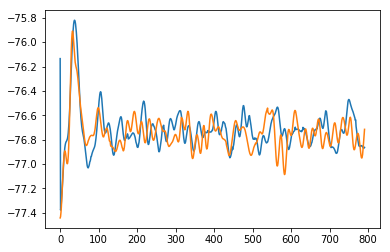

In [13]:
plt.plot(energies1)
plt.plot(energies2)
plt.show()

In [161]:
N = 300
burn = 200
idx1 = np.random.choice(np.arange(energies1.shape[0])[burn:], int(N/2), replace=False)
idx2 = np.random.choice(np.arange(energies2.shape[0])[burn:], int(N/2), replace=False)

In [162]:
confs = []
forces = []
energies = []
energies_forces = []

for i in idx1:
    
    conf = confs1[i, : , :]
    cent_atom = np.random.choice(np.arange(19))
    cent_pos = conf[cent_atom , :]
    conf = np.delete(conf, cent_atom, 0)
    conf = conf - cent_pos
    confs.append(conf)
    
    force = forces1[i, cent_atom]
    energy = energies1[i]
    
    en_for = np.hstack((energy, force))
    
    energies_forces.append(en_for)
    forces.append(force)
    energies.append(energy)
    
for i in idx2:
    
    conf = confs2[i, : , :]
    cent_atom = np.random.choice(np.arange(19))
    cent_pos = conf[cent_atom , :]
    conf = np.delete(conf, cent_atom, 0)
    conf = conf - cent_pos
    confs.append(conf)
    
    force = forces2[i, cent_atom]
    energy = energies2[i]
    
    en_for = np.hstack((energy, force))
    
    energies_forces.append(en_for)
    forces.append(force)
    energies.append(energy)
    
confs = np.array(confs)
forces = np.array(forces).flatten()
energies_forces = np.array(energies_forces).flatten()

In [163]:
def calc_gram(confs):
    N = len(confs)
    gram = np.zeros((N*3,N*3))
    for i in np.arange(N):
        for j in np.arange(N):
            gram[3*i:3*(i+1),3*j:3*(j+1)] = k3_ff(confs[i], confs[j], 1., 0.001, 100.)
            
    gram += np.identity(N*3)*0.00001
    return gram

def calc_gram_wen(confs):
    N = len(confs)
    gram = np.zeros((N*4,N*4))
    for i in np.arange(N):
        for j in np.arange(N):
            gram[4*i:4*(i+1),4*j:4*(j+1)] = ker4by4(confs[i], confs[j], 1., 0.001, 100.)
    gram += np.identity(N*4)*0.00001
    return gram

def calc_gram_en(confs):
    N = len(confs)
    gram = np.zeros((N,N))
    for i in np.arange(N):
        for j in np.arange(N):
            gram[i:(i+1),j:(j+1)] = k2_ee(confs[i], confs[j], 1., 0.001, 100.)
    gram += np.identity(N)*0.00001
    return gram

In [164]:
#gram_f = calc_gram(confs)

In [165]:
#gram_fe = calc_gram_wen(confs)

In [166]:
gram_ee = calc_gram_en(confs)

In [167]:
gram_ee.shape

(300, 300)

In [168]:
#alphas_f = np.linalg.inv(gram_f).dot(forces) 
#alphas_fe = np.linalg.inv(gram_fe).dot(energies_forces) 
alphas_e = np.linalg.inv(gram_ee).dot(energies)

In [169]:
def pred_force(conf, confs):

    kv = np.zeros((3, confs.shape[0]*3 ))
    
    for i in np.arange(confs.shape[0]):
        kv[:,3*i:3*(i+1)] = k3_ff(conf, confs[i], 1., 0.001, 100.)
    
    return kv.dot(alphas_f)


def pred_energy(conf, confs):

    kv = np.zeros((1, confs.shape[0]*3))
    
    for i in np.arange(confs.shape[0]):
        kv[:,3*i:3*(i+1)] = k3_ef(conf, confs[i], 1., 0.001, 100.)
        
    return kv.dot(alphas_f)


def pred_energy_fromen(conf, confs):

    kv = np.zeros((1, confs.shape[0]))
    
    for i in np.arange(confs.shape[0]):
        kv[:,i:(i+1)] = k2_ee(conf, confs[i], 1., 0.001, 100.)
        
    return kv.dot(alphas_e)


def pred_energy_force_we(conf, confs):

    kv = np.zeros((4, confs.shape[0]*4, ))
    
    for i in np.arange(confs.shape[0]):
        kv[:,4*i:4*(i+1)] = ker4by4(conf, confs[i], 1., 0.001, 100.)
    
    return kv.dot(alphas_fe)


## Testing energies and forces

In [170]:
Ntst = 50
burn = 200
idx1 = np.random.choice(np.arange(energies1.shape[0])[burn:], int(Ntst/2), replace=False)
idx2 = np.random.choice(np.arange(energies2.shape[0])[burn:], int(Ntst/2), replace=False)

In [171]:
confs_tst = []
forces_tst = []
energies_tst = []
energies_forces_tst = []

for i in idx1:
    
    conf = confs1[i, : , :]
    cent_atom = np.random.choice(np.arange(19))
    cent_pos = conf[cent_atom , :]
    conf = np.delete(conf, cent_atom, 0)
    conf = conf - cent_pos
    confs_tst.append(conf)
    
    force = forces1[i, cent_atom]
    energy = energies1[i]
    
    en_for = np.hstack((energy, force))
    
    energies_forces_tst.append(en_for)
    forces_tst.append(force)
    energies_tst.append(energy)
    
for i in idx2:
    
    conf = confs2[i, : , :]
    cent_atom = np.random.choice(np.arange(19))
    cent_pos = conf[cent_atom , :]
    conf = np.delete(conf, cent_atom, 0)
    conf = conf - cent_pos
    confs_tst.append(conf)
    
    force = forces2[i, cent_atom]
    energy = energies2[i]
    
    en_for = np.hstack((energy, force))
    
    energies_forces_tst.append(en_for)
    forces_tst.append(force)
    energies_tst.append(energy)
    
confs_tst = np.array(confs_tst)
forces_tst = np.array(forces_tst).flatten()
energies_forces_tst = np.array(energies_forces_tst).flatten()

### Testing energies only

In [176]:
en_preds_fromen = []

for i in np.arange(Ntst):
    en_preds_fromen.append(pred_energy_fromen(confs_tst[i], confs))


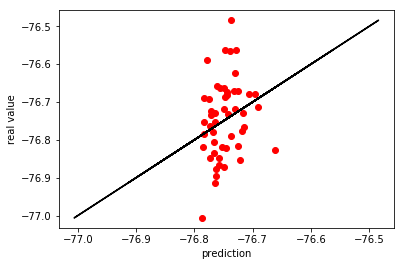

In [175]:
plt.plot(en_preds_fromen, energies_tst, 'ro')
plt.plot(energies_tst, energies_tst, 'k-')
plt.xlabel('prediction')
plt.ylabel('real value')
plt.show()

### Testing energies and forces

In [531]:
en_preds = []
f_preds = []
en_preds_we = []
f_preds_we = []

for i in np.arange(Ntst):
    en_preds.append(pred_energy(confs_tst[i], confs))
    f_preds.append(pred_force(confs_tst[i], confs))
    
    pred_we = pred_energy_force_we(confs_tst[i], confs)
    en_preds_we.append(pred_we[0])
    f_preds_we.append(pred_we[1:4])

In [532]:
f_preds = np.array(f_preds)
f_preds = np.reshape(f_preds, (f_preds.shape[0]*3))
f_preds_we = np.array(f_preds_we)
f_preds_we = np.reshape(f_preds_we, (f_preds_we.shape[0]*3))

In [533]:
en_preds = en_preds - np.mean(en_preds)
en_preds_we = en_preds_we - np.mean(en_preds_we)
energies_tst = energies_tst - np.mean(energies_tst)

In [546]:
#en_preds
fs = 13

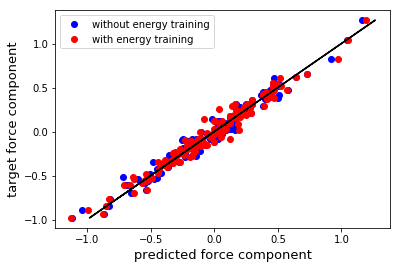

In [551]:
plt.plot(f_preds, forces_tst, 'bo', label = 'without energy training')
plt.plot(f_preds_we, forces_tst, 'ro', label = 'with energy training')
plt.plot(forces_tst, forces_tst, 'k-')
plt.xlabel('predicted force component', fontsize = fs)
plt.ylabel('target force component', fontsize = fs)
plt.legend()
plt.savefig('forces.png', dpi=250)

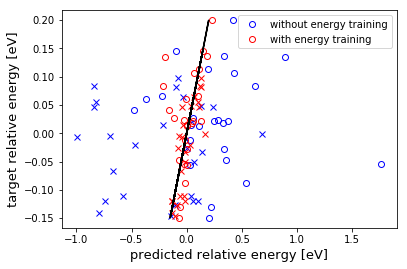

In [584]:
plt.plot(en_preds[0:int(Ntst/2)], energies_tst[0:int(Ntst/2)], color = 'b', marker = 'o', label = 'without energy training', markerfacecolor='none', lw = 0)
plt.plot(en_preds[int(Ntst/2):], energies_tst[int(Ntst/2):], color = 'b', marker = 'x', lw = 0)
plt.plot(en_preds_we[0:int(Ntst/2)], energies_tst[0:int(Ntst/2)],  color = 'r',marker = 'o', label = 'with energy training', lw = 0 ,markerfacecolor='none')
plt.plot(en_preds_we[int(Ntst/2):], energies_tst[int(Ntst/2):],  color = 'r', marker = 'x', lw = 0 )

plt.plot(energies_tst, energies_tst, 'k-')
plt.legend()
plt.xlabel('predicted relative energy [eV]', fontsize = fs)
plt.ylabel('target relative energy [eV]', fontsize = fs)
plt.savefig('energies.png', dpi=250)